# LSTM + SelfAttention
* Daily data

## Imports

In [107]:
import os
import random
import calendar
import datetime
import warnings
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import Counter
from google.cloud import bigquery
import comet_ml
from comet_ml import Experiment, Optimizer

from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

import scipy.stats
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")
tqdm.pandas()

In [108]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tqdm.keras import TqdmCallback

## Config

In [109]:
# Config
PROJECT_ID = "arpae-prod-ml"
B_CODES_TABLE = "B_CODES"

# Dataset path
dataset_path = "data/"
JOINED_BQ_DATASET = "JOINED_DATA"
DATASET_TABLE = "ALL_METEO_FEATS_WEEK_SLIDING_POL_DAT"

# Ouput
model_output = "models"

In [110]:
# ### Comet config
# experiment = Experiment(
#     api_key="JsL0DGMQDC24E7qlLa3Ksdu7I",
#     project_name="arpae-ml",
#     workspace="francesco-ruggeri",
# )

# print("Warning: put key on OS ENVIRON")

## Methods

In [111]:
def _run_query(client, query):
    df = client.query(query).to_dataframe()
    return df

def _create_station_widget(df):
    station_ids = df.station_id.sort_values().unique()
    station_wdgt = widgets.Dropdown(options=station_ids, description='Station Id:', layout={"width":"50%"})
    return station_wdgt

def _create_pol_var_id_widget(df):
    pol_var_ids = df.pol_var_id.sort_values().unique()
    pol_wdgt = widgets.Dropdown(options=pol_var_ids, description='Pol var id:', layout={"width":"50%"})
    return pol_wdgt

def _create_cluster_n_widget(df):
    cluster_ids = list(df.cluster.sort_values().unique())
    cluster_ids.append("all")
    cls_wdgt = widgets.Dropdown(options=cluster_ids, description='Cluster id:', layout={"width":"50%"})
    return cls_wdgt

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

# 1. Read Data

## 1.1 Config BigQuery

In [112]:
# Setup Client

bq_client = bigquery.Client()
bq_client

## 1.2 Read Tables

In [113]:
# Load B_CODES

sql = f"SELECT * FROM `{PROJECT_ID}.SAMPLE_DATA.{B_CODES_TABLE}` WHERE eligible IS true"
b_codes = _run_query(bq_client, sql)

print(b_codes.shape)
b_codes.head(3)

(33, 3)


,var_id,var_descr,eligible
0,B48026,"Mirtacee_Mirtacee indistinte, POLLEN/M**3",True
1,B48006,"Composite_Artemisia, POLLEN/M**3",True
2,B48041,"Spore fungine_Stemphylium, POLLEN/M**3",True


## 1.3 Load clustering results

In [114]:
### TSD Clustering
clusters = pd.read_csv("../data/clusters/clustering_tsd_intervals.csv")

### Station/Specie Clustering
# clusters = pd.read_csv("../data/clusters/clustering_intervals.csv")

print(clusters.shape)
clusters.sample(3)

(363, 3)


,station_id,pol_var_id,cluster
337,9,B48011,11
30,10,B48041,1
3,10,B48005,1


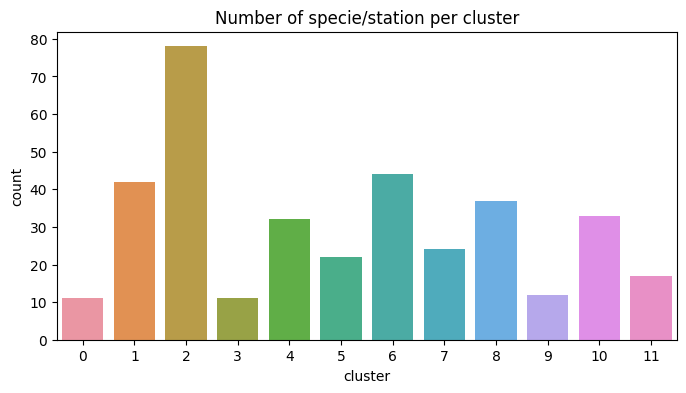

In [115]:
plt.figure(figsize=(8,4))
plt.title("Number of specie/station per cluster")
sns.countplot(x=clusters["cluster"]);

## 1.4 Load dataset

In [116]:
# Load all meteo and pollen data

sql = f"""
    SELECT DISTINCT *
    FROM `arpae-prod-ml.JOINED_DATA.ALL_METEO_FEATS_WEEK_SLIDING_POL_DAT`
    WHERE pol_var_id IN {tuple(b_codes.var_id)}
    ORDER BY station_id, pol_var_id, pol_var_date
"""

df_dataset = _run_query(bq_client, sql)

print(df_dataset.shape)
df_dataset.head(3)

(1362107, 53)


,station_id,pol_var_date,id_gepo,station_lat,station_lon,station_nome,station_H_piano_strada,station_H_mslm,arkimet_id,arkimet_lat,...,POL_mean,POL_std,POL_sum,POL_last_1,POL_last_2,POL_last_3,POL_last_4,POL_last_5,POL_last_6,POL_last_7
0,1,2006-03-01,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.5008,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2006-03-02,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.5008,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2006-03-03,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.5008,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [140]:
df_new = df_dataset.copy()
print(df_new.shape)
df_new.head(3)

(1362107, 52)


,station_id,id_gepo,station_lat,station_lon,station_nome,station_H_piano_strada,station_H_mslm,arkimet_id,arkimet_lat,arkimet_lon,...,POL_mean,POL_std,POL_sum,POL_last_1,POL_last_2,POL_last_3,POL_last_4,POL_last_5,POL_last_6,POL_last_7
pol_var_date,,,,,,,,,,,,,,,,,,,,,
2006-03-01,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.5008,11.3288,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-02,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.5008,11.3288,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-03,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.5008,11.3288,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [261]:
dataset_path = f"data/dataset_7D.feather"
df = pd.read_feather(dataset_path)
df.drop_duplicates(inplace=True)
df.date = pd.to_datetime(df.date)
df.set_index("date", inplace=True)
print(df.shape)
df.head(3)

(1271186, 38)


,station_id,pol_var_id,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,B14198_max_amax,B14198_mean_mean,...,PREC_skew,PREC_kurtosis,pol_value_amin,pol_value_mean,pol_value_std,pol_value_median,pol_value_amax,pol_value_skew,pol_value_kurtosis,pol_value_label
date,,,,,,,,,,,,,,,,,,,,,
2006-03-07,1,B48001,0.0,23.4,0.109602,0.576449,93.6,-11.0,660.0,117.337143,...,2.021117,2.121302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-03-08,1,B48001,0.0,23.4,0.109602,0.576449,93.6,-14.0,660.0,120.885714,...,2.021117,2.121302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-03-09,1,B48001,0.0,23.4,0.109602,0.576449,93.6,-14.0,660.0,132.777143,...,2.037325,2.157963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
station_id, pol_var_id = df[["station_id", "pol_var_id"]].sample(1).values[0]
station_id, pol_var_id

(1, 'B48001')

In [150]:
df_new_sample = df_new[(df_new.station_id == station_id) & (df_new.pol_var_id == pol_var_id)]
print(df_new_sample.shape)
df_new_sample[["init_date", "end_date", "pol_value", "POL_last_1"]].head(3)

(4350, 52)


,init_date,end_date,pol_value,POL_last_1
pol_var_date,,,,
2006-03-01,2006-02-21,2006-02-28,0.0,NaN
2006-03-02,2006-02-22,2006-03-01,0.0,0.0
2006-03-03,2006-02-23,2006-03-02,0.0,0.0


In [253]:
df_sample = df[(df.station_id == station_id) & (df.pol_var_id == pol_var_id)].copy()
df_sample.set_index("date", inplace=True)
print(df_sample.shape)
df_sample.head(3)

(4216, 38)


,station_id,pol_var_id,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,B14198_max_amax,B14198_mean_mean,...,PREC_skew,PREC_kurtosis,pol_value_amin,pol_value_mean,pol_value_std,pol_value_median,pol_value_amax,pol_value_skew,pol_value_kurtosis,pol_value_label
date,,,,,,,,,,,,,,,,,,,,,
2006-03-07,1,B48001,0.0,23.4,0.109602,0.576449,93.6,-11.0,660.0,117.337143,...,2.021117,2.121302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-03-08,1,B48001,0.0,23.4,0.109602,0.576449,93.6,-14.0,660.0,120.885714,...,2.021117,2.121302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-03-09,1,B48001,0.0,23.4,0.109602,0.576449,93.6,-14.0,660.0,132.777143,...,2.037325,2.157963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


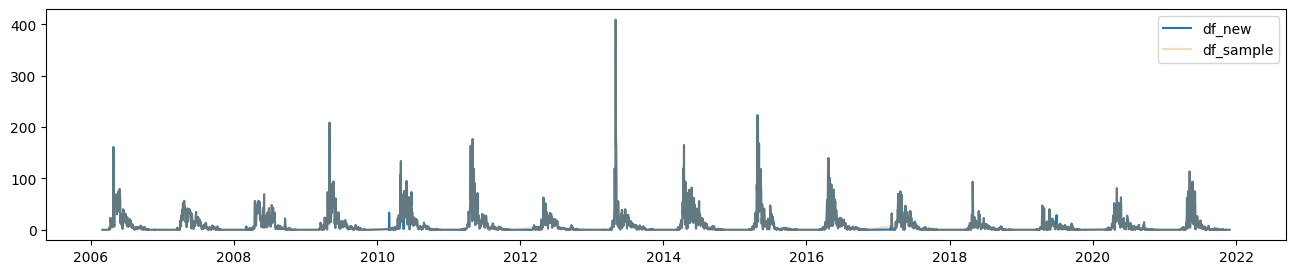

In [184]:
plt.figure(figsize=(16, 3))
plt.plot(df_new_sample.index, df_new_sample.pol_value, label="df_new")
plt.plot(df_sample.index, df_sample.pol_value_label, alpha=.3, label="df_sample")
plt.legend();

<Axes: >

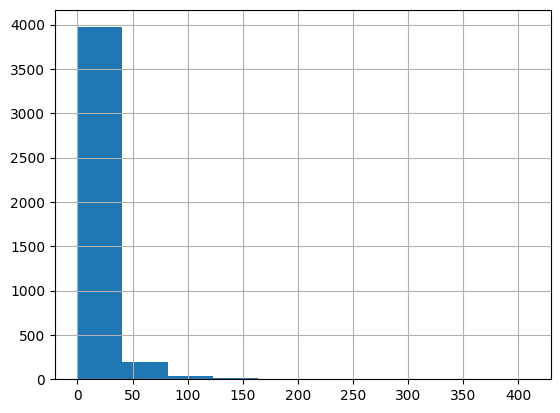

In [186]:
df_sample.pol_value_label.hist()

In [172]:
df_sample[["station_id", "pol_var_id", "pol_value_label"]].iloc[130:135]

,station_id,pol_var_id,pol_value_label
date,,,
2006-07-15,1,B48001,8.60
2006-07-16,1,B48001,7.74
2006-07-17,1,B48001,17.20
2006-07-18,1,B48001,20.64
2006-07-19,1,B48001,17.63


In [227]:
df_sample.reset_index(inplace=True)

In [228]:
df_sample.date = df_sample.date.shift(-1)

In [229]:
df_sample.dropna(inplace=True)

In [230]:
df_sample.set_index("date", inplace=True)
df_sample

,station_id,pol_var_id,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,B14198_max_amax,B14198_mean_mean,...,PREC_skew,PREC_kurtosis,pol_value_amin,pol_value_mean,pol_value_std,pol_value_median,pol_value_amax,pol_value_skew,pol_value_kurtosis,pol_value_label
date,,,,,,,,,,,,,,,,,,,,,
2006-03-08,1,B48001,0.0,23.4,0.109602,0.576449,93.6,-11.0,660.0,117.337143,...,2.021117,2.121302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-03-09,1,B48001,0.0,23.4,0.109602,0.576449,93.6,-14.0,660.0,120.885714,...,2.021117,2.121302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-03-10,1,B48001,0.0,23.4,0.109602,0.576449,93.6,-14.0,660.0,132.777143,...,2.037325,2.157963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-03-11,1,B48001,0.0,23.4,0.153630,0.737787,131.2,-14.0,660.0,134.302857,...,1.909818,1.844492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-03-12,1,B48001,0.0,23.4,0.173770,0.918141,148.4,-14.0,660.0,130.897143,...,1.909818,1.844492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25,1,B48001,0.0,5.2,0.034660,0.175936,29.6,-3.0,476.0,54.480000,...,1.807215,1.570492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-26,1,B48001,0.0,5.2,0.057611,0.222538,49.2,-3.0,476.0,46.965714,...,1.135843,-0.336576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-27,1,B48001,0.0,8.6,0.074473,0.353378,63.6,-5.0,485.0,49.382857,...,1.138891,-0.330594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [208]:
df_new_sample.keys()

Index(['station_id', 'id_gepo', 'station_lat', 'station_lon', 'station_nome',
       'station_H_piano_strada', 'station_H_mslm', 'arkimet_id', 'arkimet_lat',
       'arkimet_lon', 'meteo_id', 'init_date', 'end_date', 'B13011_max',
       'B13011_min', 'B13011_mean', 'B13011_std', 'B13011_sum', 'B14198_max',
       'B14198_min', 'B14198_mean', 'B14198_std', 'B14198_sum', 'TEMP_max',
       'TEMP_min', 'TEMP_mean', 'TEMP_std', 'TEMP_sum', 'PREC_max', 'PREC_min',
       'PREC_mean', 'PREC_std', 'PREC_sum', 'shifted_date', 'pol_var_id',
       'pol_value', 'modified', 'pol_var_descr', 'week', 'year', 'POL_max',
       'POL_min', 'POL_mean', 'POL_std', 'POL_sum', 'POL_last_1', 'POL_last_2',
       'POL_last_3', 'POL_last_4', 'POL_last_5', 'POL_last_6', 'POL_last_7'],
      dtype='object')

In [211]:
df_sample.keys()

Index(['station_id', 'pol_var_id', 'B13011_min_amin', 'B13011_max_amax',
       'B13011_mean_mean', 'B13011_std_mean', 'B13011_sum_sum',
       'B14198_min_amin', 'B14198_max_amax', 'B14198_mean_mean',
       'B14198_std_mean', 'B14198_sum_sum', 'TEMP_min_amin', 'TEMP_max_amax',
       'TEMP_mean_mean', 'TEMP_std_mean', 'TEMP_sum_sum', 'station_lat_amax',
       'station_lon_amax', 'station_H_piano_strada_amax',
       'station_H_mslm_amax', 'seasonal_amax', 'week_amax', 'PREC_amin',
       'PREC_mean', 'PREC_std', 'PREC_median', 'PREC_amax', 'PREC_skew',
       'PREC_kurtosis', 'pol_value_amin', 'pol_value_mean', 'pol_value_std',
       'pol_value_median', 'pol_value_amax', 'pol_value_skew',
       'pol_value_kurtosis', 'pol_value_label'],
      dtype='object')

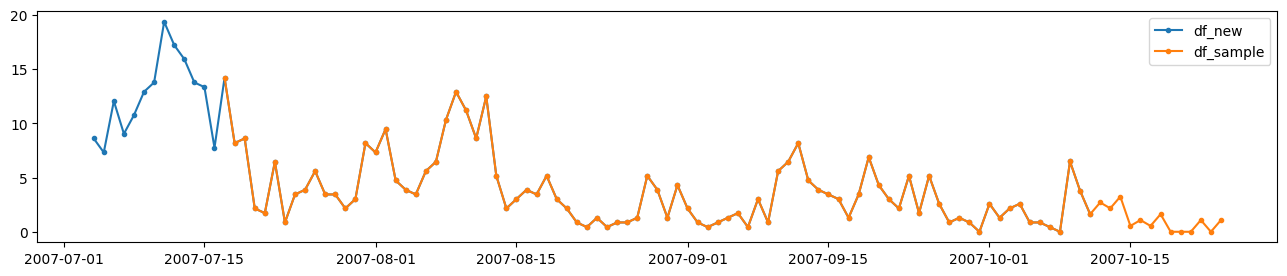

In [231]:
plt.figure(figsize=(16, 3))
a = 400
b = a+100

plt.plot(df_new_sample.iloc[a:b][["pol_value"]], ".-", label="df_new")
plt.plot(df_sample.iloc[a:b][["pol_value_label"]], ".-", label="df_sample")
plt.legend(loc="upper right");

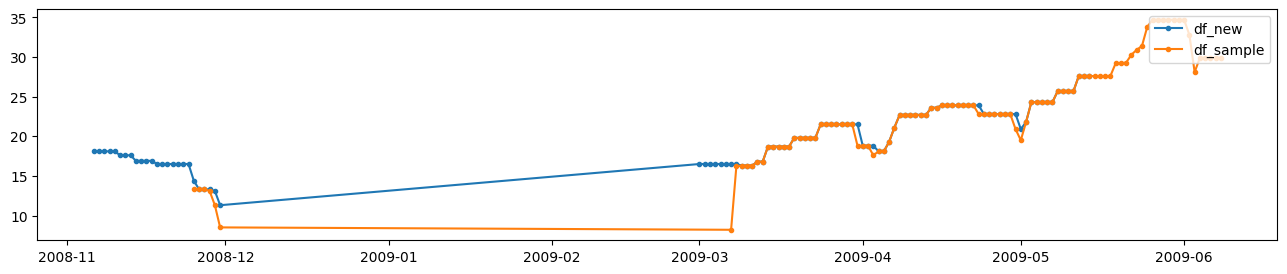

In [236]:
plt.figure(figsize=(16, 3))
a = 800
b = a+100

plt.plot(df_new_sample.iloc[a:b][["TEMP_max"]], ".-", label="df_new")
plt.plot(df_sample.iloc[a:b][["TEMP_max_amax"]], ".-", label="df_sample")
plt.legend(loc="upper right");

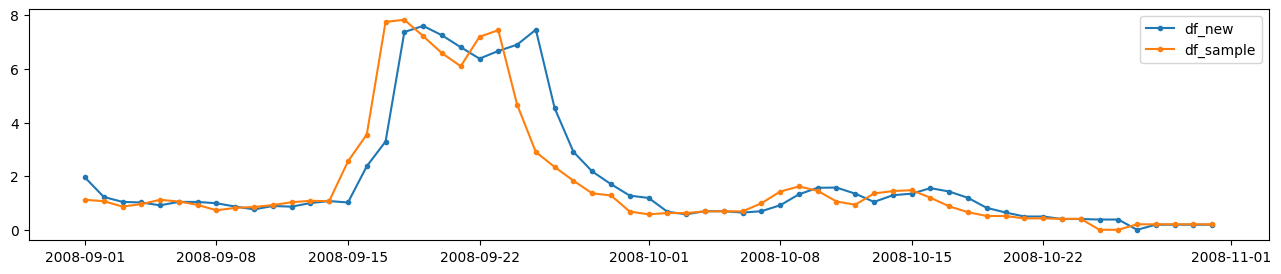

In [299]:
plt.figure(figsize=(16, 3))
a = "2008-09-01"
b = "2008-10-31"

plt.plot(df_new_sample.loc[a:b][["POL_std"]], ".-", label="df_new")
plt.plot(df_sample.loc[a:b][["pol_value_std"]], ".-", label="df_sample")
plt.legend(loc="upper right");

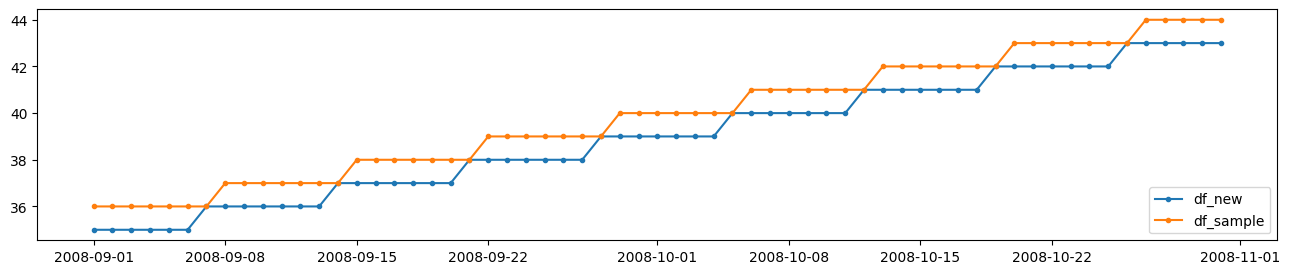

In [302]:
plt.figure(figsize=(16, 3))
a = "2008-09-01"
b = "2008-10-31"

plt.plot(df_new_sample.loc[a:b][["week"]], ".-", label="df_new")
plt.plot(df_sample.loc[a:b][["week_amax"]], ".-", label="df_sample")
plt.legend(loc="lower right");

In [303]:
### Verify WINDOWS agg features
### normalizzare temp all (non in coppie)
### AdamX

In [ ]:
2017-05-07
2
B48001
139.75

In [280]:
df[["station_id", "pol_var_id", "pol_value_label"]][(df.station_id == 2) & (df.pol_var_id=="B48001")].iloc[2479:]

,station_id,pol_var_id,pol_value_label
date,,,
2017-05-01,2,B48001,6.45
2017-05-09,2,B48001,10.75
2017-05-10,2,B48001,105.35
2017-05-11,2,B48001,104.06
2017-05-12,2,B48001,302.72
...,...,...,...
2019-11-07,2,B48001,0.00
2019-11-08,2,B48001,0.00
2019-11-09,2,B48001,0.00


In [259]:
df.date

0         2006-03-07
1         2006-03-08
2         2006-03-09
3         2006-03-10
4         2006-03-11
             ...    
1271181   2021-10-26
1271182   2021-10-27
1271183   2021-10-28
1271184   2021-10-29
1271185   2021-10-30
Name: date, Length: 1271186, dtype: datetime64[ns]

In [237]:
df_new_sample.keys()

Index(['station_id', 'id_gepo', 'station_lat', 'station_lon', 'station_nome',
       'station_H_piano_strada', 'station_H_mslm', 'arkimet_id', 'arkimet_lat',
       'arkimet_lon', 'meteo_id', 'init_date', 'end_date', 'B13011_max',
       'B13011_min', 'B13011_mean', 'B13011_std', 'B13011_sum', 'B14198_max',
       'B14198_min', 'B14198_mean', 'B14198_std', 'B14198_sum', 'TEMP_max',
       'TEMP_min', 'TEMP_mean', 'TEMP_std', 'TEMP_sum', 'PREC_max', 'PREC_min',
       'PREC_mean', 'PREC_std', 'PREC_sum', 'shifted_date', 'pol_var_id',
       'pol_value', 'modified', 'pol_var_descr', 'week', 'year', 'POL_max',
       'POL_min', 'POL_mean', 'POL_std', 'POL_sum', 'POL_last_1', 'POL_last_2',
       'POL_last_3', 'POL_last_4', 'POL_last_5', 'POL_last_6', 'POL_last_7'],
      dtype='object')

In [238]:
df_sample.keys()

Index(['station_id', 'pol_var_id', 'B13011_min_amin', 'B13011_max_amax',
       'B13011_mean_mean', 'B13011_std_mean', 'B13011_sum_sum',
       'B14198_min_amin', 'B14198_max_amax', 'B14198_mean_mean',
       'B14198_std_mean', 'B14198_sum_sum', 'TEMP_min_amin', 'TEMP_max_amax',
       'TEMP_mean_mean', 'TEMP_std_mean', 'TEMP_sum_sum', 'station_lat_amax',
       'station_lon_amax', 'station_H_piano_strada_amax',
       'station_H_mslm_amax', 'seasonal_amax', 'week_amax', 'PREC_amin',
       'PREC_mean', 'PREC_std', 'PREC_median', 'PREC_amax', 'PREC_skew',
       'PREC_kurtosis', 'pol_value_amin', 'pol_value_mean', 'pol_value_std',
       'pol_value_median', 'pol_value_amax', 'pol_value_skew',
       'pol_value_kurtosis', 'pol_value_label'],
      dtype='object')

In [294]:
df_new_sample["POL_std"].describe()

count    4332.000000
mean        5.937428
std        10.753265
min         0.000000
25%         0.583167
50%         2.016879
75%         6.681635
max       127.964342
Name: POL_std, dtype: float64

In [295]:
df_sample["pol_value_std"].describe()

count    4216.000000
mean        5.841583
std        10.755753
min         0.000000
25%         0.593456
50%         2.001920
75%         6.509110
max       135.554356
Name: pol_value_std, dtype: float64

<Axes: >

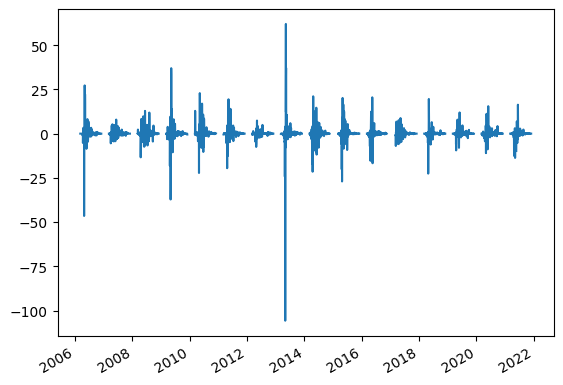

In [293]:
(df_new_sample["POL_std"] - df_sample["pol_value_std"]).plot()

<Axes: >

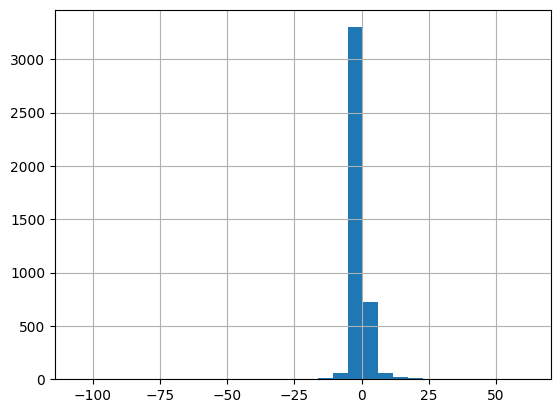

In [292]:
(df_new_sample["POL_std"] - df_sample["pol_value_std"]).hist(bins=30)

In [297]:
df_new_sample.shape, df_sample.shape

((4350, 52), (4216, 38))

In [298]:
(df_new_sample["POL_std"] - df_sample["pol_value_std"]).shape

(4350,)

In [202]:
date_rng = pd.date_range(start='1/1/2022', end='1/5/2022', freq='D')
date_rng = np.hstack([date_rng, date_rng])
df = pd.DataFrame(date_rng, columns=['date'])
df['station_id'] = ['A']*5 + ['B']*5
df['pol_var_id'] = ['X']*5 + ['Y']*5 #['X']*3 + ['Y']*2 + ['X']*3 + ['Y']*2
df['data1'] = np.random.randint(0,10,size=(len(date_rng)))
df['data2'] = np.random.randint(0,10,size=(len(date_rng)))
df.set_index(['date'], inplace=True)
display(df)

# Sort df
df = df.sample(frac=1).sort_values(["station_id", "pol_var_id", "date"])

# Define aggregation functions and column names
aggregating_functions = {
    "data1": ["max", "min"],
    "data2": [np.median, scipy.stats.skew, scipy.stats.kurtosis],
}

# Group by Station/Pollen
df_rolled = df.groupby(["station_id", "pol_var_id"])

# Apply rolling window
window_day_size = 4
df_rolled = df_rolled.rolling(window=f"{window_day_size}D", min_periods=window_day_size, center=False)

# Apply rolling window and aggregate
df_rolled = df_rolled.agg(aggregating_functions)

# df_rolled.columns = column_names
df_rolled.columns = list(map(lambda c: "_".join(c) if all(c) else c[0], df_rolled.columns))
df_rolled.dropna(inplace=True)
df_rolled.reset_index(inplace=True)
df_rolled.set_index('date', inplace=True)
display(df_rolled)

,station_id,pol_var_id,data1,data2
date,,,,
2022-01-01,A,X,3,2
2022-01-02,A,X,8,1
2022-01-03,A,X,8,4
2022-01-04,A,X,0,6
2022-01-05,A,X,5,1
2022-01-01,B,Y,2,1
2022-01-02,B,Y,2,8
2022-01-03,B,Y,4,2
2022-01-04,B,Y,8,5


,station_id,pol_var_id,data1_max,data1_min,data2_median,data2_skew,data2_kurtosis
date,,,,,,,
2022-01-04,A,X,8.0,0.0,3.0,0.278031,-1.426602
2022-01-05,A,X,8.0,0.0,2.5,0.314270,-1.592593
2022-01-04,B,Y,8.0,2.0,3.5,0.365148,-1.426667
2022-01-05,B,Y,8.0,1.0,6.0,-0.498784,-1.238095


In [281]:
df_new

,station_id,id_gepo,station_lat,station_lon,station_nome,station_H_piano_strada,station_H_mslm,arkimet_id,arkimet_lat,arkimet_lon,...,POL_mean,POL_std,POL_sum,POL_last_1,POL_last_2,POL_last_3,POL_last_4,POL_last_5,POL_last_6,POL_last_7
pol_var_date,,,,,,,,,,,,,,,,,,,,,
2006-03-01,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-02,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-03,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2006-03-04,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2006-03-05,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.50080,11.3288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-28,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-29,13,4190,44.6552,11.6231,San Pietro Capofiume,10.0,31.0,San Pietro Capofiume,4.65378,11.6226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [287]:
df_new[(df_new.station_id == 2) & (df_new.pol_var_id=="B48021") & (df_new.index == "2012-04-08")][["init_date", "end_date", "pol_value"]] #[["station_id", "pol_var_id", "pol_value_label"]]

,init_date,end_date,pol_value
pol_var_date,,,
2012-04-08,2012-03-31,2012-04-07,119.11


___

# 2. Data preprocess

In [117]:
# Convert dates to datetime format
df_dataset.pol_var_date = pd.to_datetime(df_dataset.pol_var_date)

In [118]:
# Sort dataset
df_dataset.sort_values(["station_id", "pol_var_id", "pol_var_date"], inplace=True)

In [119]:
# Set datetime as index
df_dataset.set_index("pol_var_date", inplace=True)

In [120]:
print(df_dataset.shape)
df_dataset.head(3)

(1362107, 52)


,station_id,id_gepo,station_lat,station_lon,station_nome,station_H_piano_strada,station_H_mslm,arkimet_id,arkimet_lat,arkimet_lon,...,POL_mean,POL_std,POL_sum,POL_last_1,POL_last_2,POL_last_3,POL_last_4,POL_last_5,POL_last_6,POL_last_7
pol_var_date,,,,,,,,,,,,,,,,,,,,,
2006-03-01,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.5008,11.3288,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-02,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.5008,11.3288,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-03,1,4181,44.4914,11.3694,Bologna,80.0,101.0,Bologna urbana,44.5008,11.3288,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


___

# 3. Select data

### 3.1 Select Cluster

In [121]:
# Select species/stations from cluster result
def select_cluster_species(df, clusters, cluster_n):
    # Select Cluster pollen ids
    if cluster_n == "all":
        specie_cluster = clusters
    else:
        specie_cluster = clusters[clusters.cluster == cluster_n]

    # Select species/stations from cluster result
    df_feature = pd.merge(df.reset_index(), specie_cluster, on=["station_id", "pol_var_id"], how="inner")
    df_feature.station_id = df_feature.station_id.astype(int)
    df_feature.dropna(inplace=True)
    df_feature.set_index("pol_var_date", inplace=True)

    assert len(specie_cluster) == len(df_feature[["station_id", "pol_var_id"]].drop_duplicates())
    return df_feature

### 3.4 Specie and station are added as a categorical feature to our model

In [122]:
def one_hot_encode_feat(df, columns):
    for col in columns:
        # Encode feature
        var_enc = pd.get_dummies(df[col], prefix=col)

        # Add one-hot encoded values to original dataframe
        df = pd.concat([df, var_enc], axis=1)
    return df

### 3.5 Select features

In [123]:
def select_features(df, features, columns_to_shift, columns_to_encode):
    # Add previous pollen day
    for col in columns_to_shift:
        shifted_feature_names = df.keys()[df.keys().str.contains(f"{col}_prev")]
        features.extend(shifted_feature_names.tolist())

    # Add one hot encodings of station and species
    for col in columns_to_encode:
        col_one_hot = df.keys()[df.keys().str.contains(f"{col}_")]
        features.extend(col_one_hot.tolist())
        
    # Add last pollen days
    pol_cols = list(filter(lambda c: "POL_last_" in c, df_dataset.keys()))
    features.extend(col_one_hot.tolist())

    features = np.array(features)
    return features

### 3.6 Training/test split

In [124]:
def split_group(group):
    # Get group indexes
    group_idxs = group.index.values
    group_len = len(group_idxs)

    # Evaluate indexes for each split
    train_end = int(group_len * training_size)
    test_end = int(group_len * (training_size + test_size))
    val_end = int(group_len * (training_size + test_size + valid_size))

    # Selecting splits from indexes
    train_idx = group_idxs[:train_end]
    test_idx = group_idxs[train_end:test_end]
    val_idx = group_idxs[test_end:]

    return train_idx, test_idx, val_idx


def train_test_valid_split(df, y_label):
    # Set index back to integers
    df = df.copy()
    df.reset_index(inplace=True)

    # Group by station and pollen
    groups = df.groupby(["station_id", "pol_var_id"])

    # Split group indexes
    indexes = groups.apply(split_group).values
    indexes = np.array(indexes)

    # Parse group indexes
    training_idxs = np.hstack([np.sort(idxs[0]) for idxs in indexes])
    test_idxs = np.hstack([np.sort(idxs[1]) for idxs in indexes])
    valid_idxs = np.hstack([np.sort(idxs[2]) for idxs in indexes])

    # Create X, y from dataset
    X = df  # [features]
    y = df[[y_label, "pol_var_date"]]

    # Split using indexes
    x_train, y_train = X.loc[training_idxs], y.loc[training_idxs]
    x_test, y_test = X.loc[test_idxs], y.loc[test_idxs]
    x_valid, y_valid = X.loc[valid_idxs], y.loc[valid_idxs]

    x_train.set_index("pol_var_date", inplace=True)
    y_train.set_index("pol_var_date", inplace=True)
    x_test.set_index("pol_var_date", inplace=True)
    y_test.set_index("pol_var_date", inplace=True)
    x_valid.set_index("pol_var_date", inplace=True)
    y_valid.set_index("pol_var_date", inplace=True)

    return x_train, y_train, x_test, y_test, x_valid, y_valid

### 3.7 Create timeseries_dataset_from_array

In [125]:
def create_timeseries_dataset(features, x_train, y_train, x_test, y_test, x_valid, y_valid):
    train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        x_train[features],
        y_train,
        sequence_length=window_day_size,
        batch_size=batch_size,
    )

    test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        x_test[features],
        y_test,
        sequence_length=window_day_size,
        batch_size=batch_size,
    )

    valid_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        x_valid[features],
        y_valid,
        sequence_length=window_day_size,
        batch_size=batch_size,
    )

    return train_dataset, test_dataset, valid_dataset

___

# 4. Model definition

### LSTM, MultiHeadAttention

In [134]:
# def get_model(features_shape=None, get_name=False):
#     if get_name: return "MultiHeadAttention"
    
#     # Define model inputs
#     input_layer = tf.keras.layers.Input(shape=(window_day_size, features_shape))

#     # LSTM Layer
#     lstm_1 = tf.keras.layers.LSTM(units=512, dropout=.2, return_sequences=True)(input_layer)
#     lstm_2 = tf.keras.layers.LSTM(units=256, dropout=.2, return_sequences=True)(lstm_1)
#     lstm_3 = tf.keras.layers.LSTM(units=128, dropout=.2, return_sequences=True)(lstm_2)

#     ### Multi head attention
#     attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=lstm_3, value=lstm_3, key=lstm_3)
#     attn_output = tf.keras.layers.Dense(units=128)(attn_layer)

#     # Reshape attention layer
#     att_reshape = tf.keras.layers.Flatten()(attn_output)

#     # Dense layer
#     dense_lst_1 = tf.keras.layers.Dense(units=128)(att_reshape)
#     dropout_1 = tf.keras.layers.Dropout(.2)(dense_lst_1)
#     dense_lst_2 = tf.keras.layers.Dense(units=64)(dropout_1)
#     dropout_2 = tf.keras.layers.Dropout(.2)(dense_lst_2)
#     dense_lst_3 = tf.keras.layers.Dense(units=32)(dropout_2)

#     # Output layer
#     output_layer = tf.keras.layers.Dense(units=1)(dense_lst_3)

#     # Define model architecture
#     model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

#     # Optimizer
#     optimizer = Adam(learning_rate=learning_rate)
#     #lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=100, decay_rate=1, staircase=False)
#     #optimizer = Adam(learning_rate=lr_schedule)

#     model.compile(optimizer=optimizer, loss="mse")
#     return model

# # def get_model(features_shape):
# #     # Define model inputs
# #     input_layer = tf.keras.layers.Input(shape=(window_day_size, features_shape))

# #     ### Multi head attention
# #     attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=input_layer, value=input_layer, key=input_layer)
# #     attn_output = tf.keras.layers.Dense(units=64, activation="relu")(attn_layer)

# #     # Reshape attention layer
# #     att_reshape = tf.keras.layers.Flatten()(attn_output)

# #     # Dense layer
# #     dense_lst_1 = tf.keras.layers.Dense(units=64, activation="relu")(att_reshape)
# #     dropout_1 = tf.keras.layers.Dropout(.2)(dense_lst_1)
# #     dense_lst_2 = tf.keras.layers.Dense(units=16, activation="relu")(dropout_1)

# #     # Output layer
# #     output_layer = tf.keras.layers.Dense(units=1)(dense_lst_2)

# #     # Define model architecture
# #     model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# #     # Optimizer
# #     optimizer = Adam(learning_rate=learning_rate)
# #     #lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=100, decay_rate=1, staircase=False)
# #     #optimizer = Adam(learning_rate=lr_schedule)

# #     model.compile(optimizer=optimizer, loss="mse")
# #     return model

In [135]:
def get_model(features_shape=None, get_name=False):
    if get_name: return "MultiHeadAttention"

    # Define model inputs
    input_layer = tf.keras.layers.Input(shape=(window_day_size, features_shape))

    ### Multi head attention
    attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=input_layer, value=input_layer, key=input_layer)
    attn_output = tf.keras.layers.Dense(units=64, activation="relu")(attn_layer)

    # Reshape attention layer
    att_reshape = tf.keras.layers.Flatten()(attn_output)

    # Dense layer
    dense_lst_1 = tf.keras.layers.Dense(units=128)(att_reshape)
    dropout_1 = tf.keras.layers.Dropout(.2)(dense_lst_1)
    dense_lst_2 = tf.keras.layers.Dense(units=64)(dropout_1)

    # Output layer
    output_layer = tf.keras.layers.Dense(units=1)(dense_lst_2)

    # Define model architecture
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")
    return model

In [128]:
# ## nice, normalized data
# def get_model(features_shape):
#     # Define model inputs
#     input_layer = tf.keras.layers.Input(shape=(window_day_size, features_shape))

#     # LSTM layers
#     lstm_1 = tf.keras.layers.LSTM(units=128, return_sequences=True)(input_layer)
#     lstm_2 = tf.keras.layers.LSTM(units=64)(lstm_1)

#     # Dense layer
#     dense_lst_1 = tf.keras.layers.Dense(units=32)(lstm_2)
#     dense_lst_2 = tf.keras.layers.Dense(units=16)(dense_lst_1)

#     # Output layer
#     output_layer = tf.keras.layers.Dense(units=1)(dense_lst_2)

#     # Define model architecture
#     model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

#     # Define optimizer
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss="mse")

#     # optimizer = Adam(learning_rate=learning_rate)
#     # model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta=huber_delta, name="loss"))

#     return model

___

# 5. Training Pipeline

In [129]:
def get_processed_data(cluster_n, log=False):
    # Select data from cluster (all if cluster_n is None)
    df_feature = select_cluster_species(df_dataset, clusters, cluster_n=cluster_n)

    # Convert features to one hot encoding
    df_feature = one_hot_encode_feat(df_feature, columns_to_encode)

    if log:
        print("Dataset shape:", df_feature.shape)

    # Select features
    todrop = ["arkimet_id", "station_id", "pol_var_id", "cluster", "pol_value", 'end_date', 'id_gepo', 'init_date', 'meteo_id', 'modified', 'pol_var_descr','shifted_date', 'station_nome', 'year']
    features = list(df_feature.drop(todrop, axis=1).keys())
    y_label = "pol_value"

    features = select_features(df_feature, features, [], columns_to_encode)
    if log:
        print(len(features), "features")
        print("Features: ", sorted(features))
    
    df_feature.week = df_feature.week.astype(int)
    
    x_train, y_train, x_test, y_test, x_valid, y_valid = train_test_valid_split(df_feature, y_label)
    if log:
        print(f"x_training_size: {x_train.shape}, x_test_size: {x_test.shape}, x_valid_size: {x_valid.shape}")
    if log:
        print(f"y_training_size: {y_train.shape}, y_test_size: {y_test.shape}, y_valid_size: {y_valid.shape}")

    ### Verify station/pollen split dates
    # x_train.reset_index().groupby(["station_id","pol_var_id"]).date.agg([min, max]).head()
    # x_test.reset_index().groupby(["station_id","pol_var_id"]).date.agg([min, max]).head()
    # x_valid.reset_index().groupby(["station_id","pol_var_id"]).date.agg([min, max]).head()

    train_dataset, test_dataset, valid_dataset = create_timeseries_dataset(features, x_train, y_train, x_test, y_test, x_valid, y_valid)

    class dataset: pass
    dataset.cluster_n = cluster_n
    dataset.features = features
    dataset.x_train = x_train
    dataset.y_train = y_train
    dataset.x_test = x_test
    dataset.y_test = y_test
    dataset.x_valid = x_valid
    dataset.y_valid = y_valid
    dataset.train_dataset = train_dataset
    dataset.test_dataset = test_dataset
    dataset.valid_dataset = valid_dataset
    return dataset

# get_processed_data(cluster_n=0, log=False).x_train[get_processed_data(cluster_n=0, log=False).features].iloc[0].to_dict()
# get_processed_data(cluster_n=0, log=False).x_train[get_processed_data(cluster_n=0, log=False).features].dtypes.values
# get_processed_data(cluster_n=0, log=False).features[26]

In [130]:
def train_model(dataset, log=False):
    model_name = f"lstm_self-att_daily_cluster-{dataset.cluster_n}"
    model_output_path = f"{model_output}/{model_name}.h5"

    if os.path.exists(model_output_path):
        !rm $model_output_path

    print(f"Training model for cluster: {dataset.cluster_n}. Output folder: {model_output_path}")

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
    early_stop = EarlyStopping(monitor="val_loss", patience=15, verbose=1, mode="min", restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_output_path, monitor="val_loss", mode="min", save_best_only=True)

    model = get_model(len(dataset.features))
    if log:
        print(model.summary())

    history = model.fit(
        dataset.train_dataset,
        validation_data=dataset.test_dataset,
        epochs=n_epochs,
        shuffle=True,
        verbose=0,
        callbacks=[early_stop, model_checkpoint, reduce_lr, TqdmCallback(verbose=1)],
    )

    # Load the best model
    print("Loading best model")
    model = tf.keras.models.load_model(model_output_path)

    return history, model

## 5.1 Params

In [136]:
how_many_previous_days = 0
columns_to_shift = [] #"pol_value_label"]  # , "PREC", 'TEMP_min', 'TEMP_max', "TEMP_sum"]
columns_to_encode = ["station_id", "pol_var_id"]

training_size, test_size = 0.75, 0.2
valid_size = np.round(1 - training_size - test_size, 5)

batch_size = 2048
window_day_size = 7

n_epochs = 100
learning_rate = 0.001

print("training_size:", training_size, "test_size:", test_size, "valid_size:", valid_size)

training_size: 0.75 test_size: 0.2 valid_size: 0.05


In [137]:
### Choose clusters for training and test
all_clusters = sorted(clusters.cluster.unique())
# all_clusters.append("all")

# for g purpose
# all_clusters = random.sample(all_clusters, 2)
all_clusters = [2]#, 5]

print(f"Training clusters: {all_clusters}")

Training clusters: [2]


## 5.2 Launch training pipeline

In [138]:
trainings = []
for cluster_n in tqdm(all_clusters):
    model_name = get_model(get_name=True)
    model_identifier = f"{model_name}_{window_day_size}D_Cluster-{cluster_n}"
    
    #experiment = Experiment(api_key="JsL0DGMQDC24E7qlLa3Ksdu7I", project_name="arpae-ml", workspace="francesco-ruggeri")
    #experiment.set_name(model_identifier)
    
    # Get dataset
    dataset = get_processed_data(cluster_n=cluster_n, log=False)

    # Train dataset
    dataset.history, dataset.model = train_model(dataset)

    # Store results
    trainings.append(dataset)
    
    experiment.end();

  0%|          | 0/1 [00:00<?, ?it/s]

Training model for cluster: 2. Output folder: models/lstm_self-att_daily_cluster-2.h5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

KeyboardInterrupt: 

___

# 6. Results

## 6.1 Loss training history

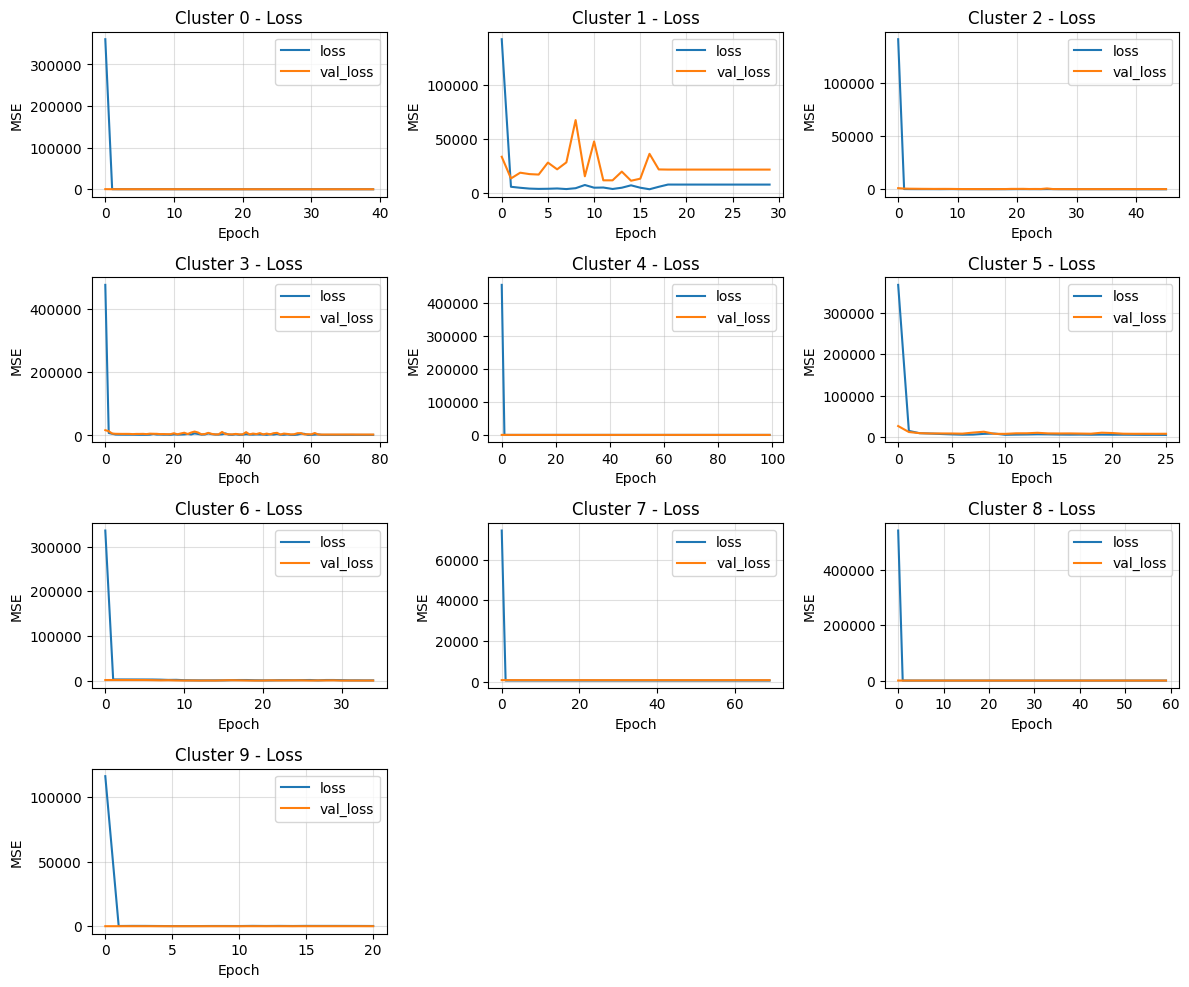

In [91]:
rows, cols = 5, 3
fig, axs = plt.subplots(rows, cols, figsize=(12, 12), squeeze=False)
for subpltn, dataset in enumerate(trainings):
    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - Loss")
    ax.plot(dataset.history.history["loss"])
    ax.plot(dataset.history.history["val_loss"])
    ax.set_ylabel("MSE")
    ax.set_xlabel("Epoch")
    ax.legend(["loss", "val_loss"], loc="upper right")
    ax.grid(alpha=0.4)
for subpltn in range(subpltn + 1, rows * cols):
    fig.delaxes(axs.flatten()[subpltn])  # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

## 6.2 Models MSE Train/Test/Valid

In [ ]:
# cluster_model_mse = []
# for dataset in tqdm(trainings):
#     cluster_model_mse.append({
#         "cluster_n": dataset.cluster_n,
#         "train_mse": dataset.model.evaluate(dataset.train_dataset, verbose=False),
#         "test_mse": dataset.model.evaluate(dataset.test_dataset, verbose=False),
#         "valid_mse": dataset.model.evaluate(dataset.valid_dataset, verbose=False),
#     })
# cluster_model_mse = pd.DataFrame(cluster_model_mse)

# fig, ax = plt.subplots(figsize=(10, 4))
# cluster_model_mse.plot(x='cluster_n', kind='bar', ax=ax)
# ax.set_title('Mean Squared Error vs. Cluster Size')
# ax.set_xlabel('Cluster Size')
# ax.set_ylabel('Mean Squared Error')
# # plt.yscale("symlog")
# plt.grid(alpha=.4)
# plt.show()

## 6.3 Training/Test Model Predictions

In [ ]:
# ### Test on training data
# rows, cols = 4, 3
# fig, axs = plt.subplots(rows, cols, figsize=(14,10), squeeze=False)
# for subpltn, dataset in enumerate(trainings):
#     predictions = dataset.model.predict(dataset.train_dataset, verbose=False).squeeze()
#     mse = dataset.model.evaluate(dataset.train_dataset, verbose=False)

#     ax = axs[divmod(subpltn, cols)]
#     ax.set_title(f"Cluster {dataset.cluster_n} - Training preditcions - MSE: {np.round(mse, 2)}")
#     ax.scatter(dataset.y_train.index, dataset.y_train.values, s=3, c="green", label="pol_value true")
#     ax.scatter(dataset.y_train.index[window_day_size-1:], predictions, s=3, c="red", label="pol_value predicted")
#     ax.set_ylabel('Pollen')
#     ax.set_xlabel('Date')
#     ax.grid(alpha=.4)

# for subpltn in range(subpltn+1, rows*cols): fig.delaxes(axs.flatten()[subpltn]) # removing empty plots from subplot grid
# plt.tight_layout()
# plt.show();

In [ ]:
# ### Test on test data
# rows, cols = 4, 3
# fig, axs = plt.subplots(rows, cols, figsize=(14,10), squeeze=False)
# for subpltn, dataset in enumerate(trainings):
#     predictions = dataset.model.predict(dataset.test_dataset, verbose=False).squeeze()
#     mse = dataset.model.evaluate(dataset.test_dataset, verbose=False)

#     ax = axs[divmod(subpltn, cols)]
#     ax.set_title(f"Cluster {dataset.cluster_n} - Test preditcions - MSE: {np.round(mse, 2)}")
#     ax.scatter(dataset.y_test.index, dataset.y_test.values, s=3, c="green", label="pol_value true")
#     ax.scatter(dataset.y_test.index[window_day_size-1:], predictions, s=3, c="red", label="pol_value predicted")
#     ax.set_ylabel('Pollen')
#     ax.set_xlabel('Date')
#     ax.grid(alpha=.4)

# for subpltn in range(subpltn+1, rows*cols): fig.delaxes(axs.flatten()[subpltn]) # removing empty plots from subplot grid
# plt.tight_layout()
# plt.show();

## 6.4 Validation data

In [ ]:
### Test on validation data
rows, cols = 6, 2
fig, axs = plt.subplots(rows, cols, figsize=(14, 10), squeeze=False)
for subpltn, dataset in enumerate(trainings):
    predictions = dataset.model.predict(dataset.valid_dataset, verbose=False).squeeze()
    mse = dataset.model.evaluate(dataset.valid_dataset, verbose=False)

    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - Validation preditcions - MSE: {np.round(mse, 2)}")

    ax.scatter(dataset.y_valid.index[: -window_day_size + 1], dataset.y_valid[: -window_day_size + 1].values, s=3, c="green", label="pol_value true")
    ax.scatter(dataset.y_valid.index[: -window_day_size + 1], predictions, s=3, c="red", label="pol_value predicted")

    ax.set_ylabel("Pollen")
    ax.set_xlabel("Date")
    ax.grid(alpha=0.4)

for subpltn in range(subpltn + 1, rows * cols):
    fig.delaxes(axs.flatten()[subpltn])  # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

## 6.5 Validation data - Single cluster, all specie/pollen

In [ ]:
# cluster_wgt = _create_cluster_n_widget(clusters)
# display(cluster_wgt)

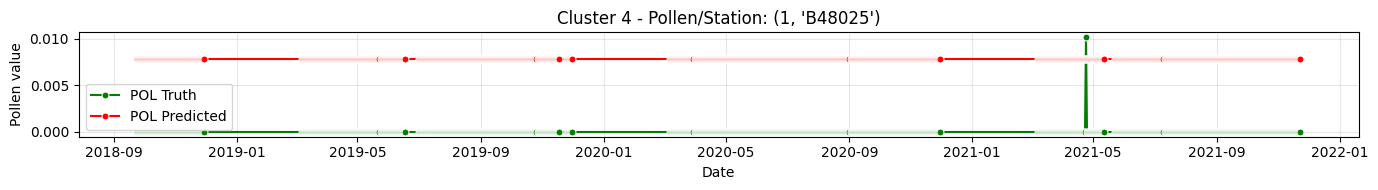

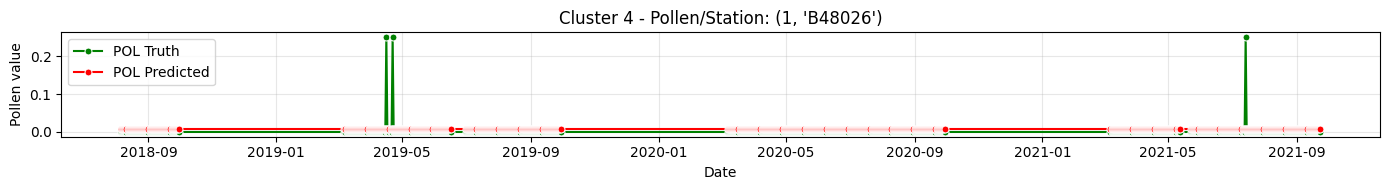

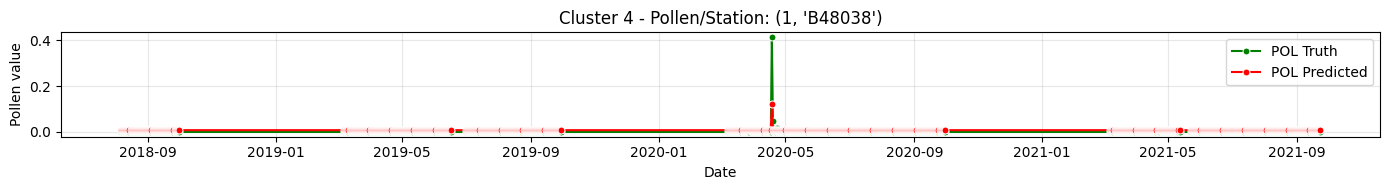

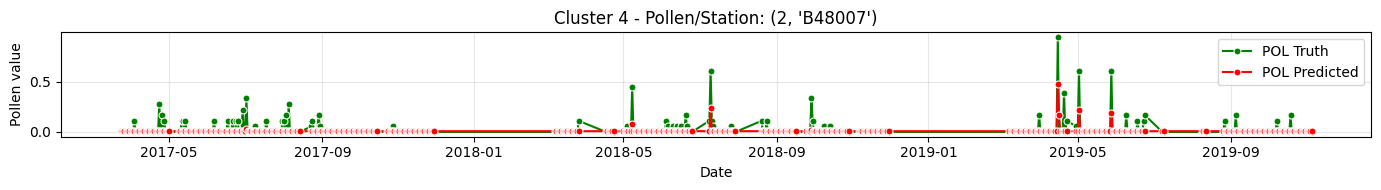

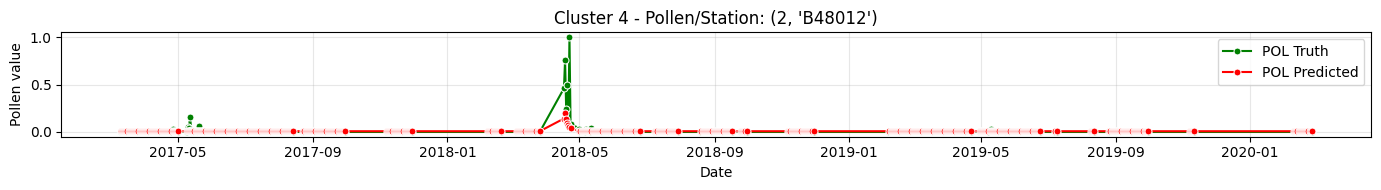

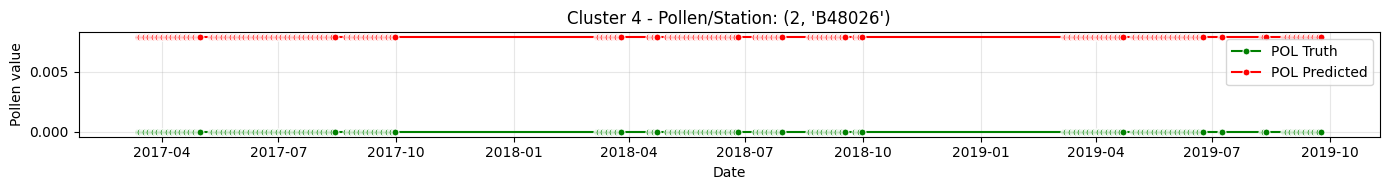

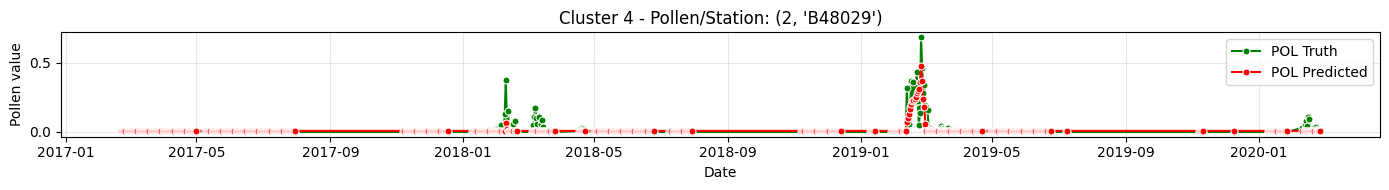

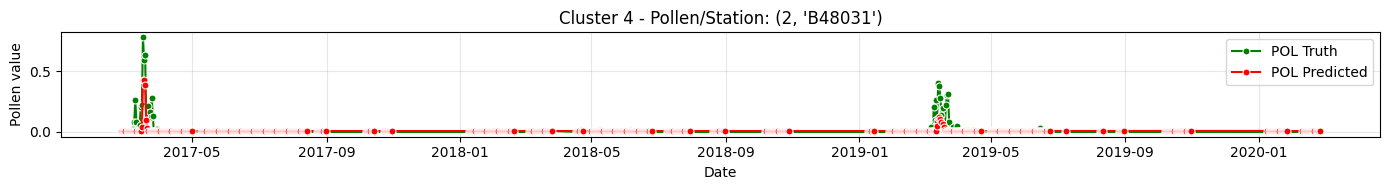

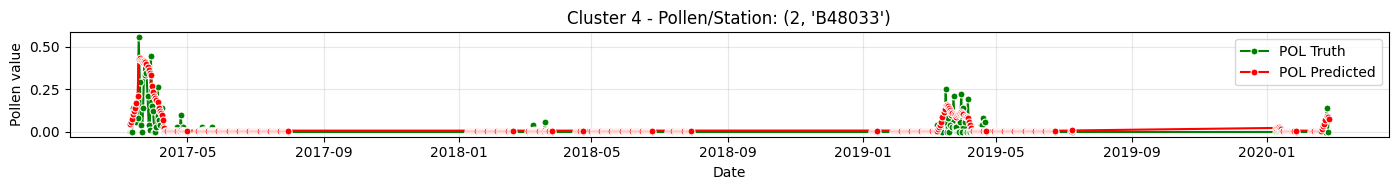

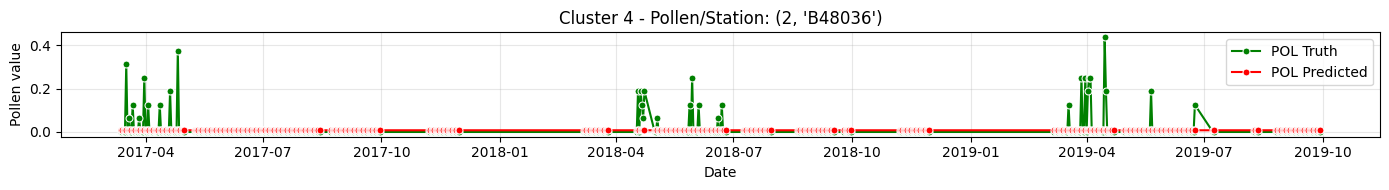

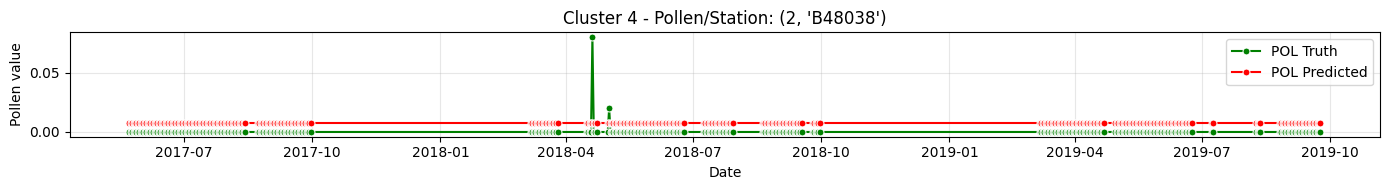

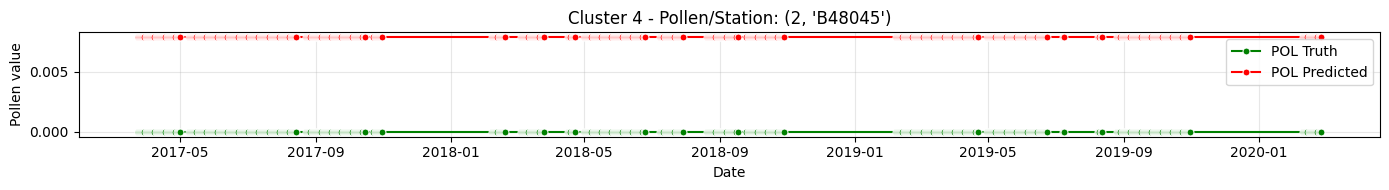

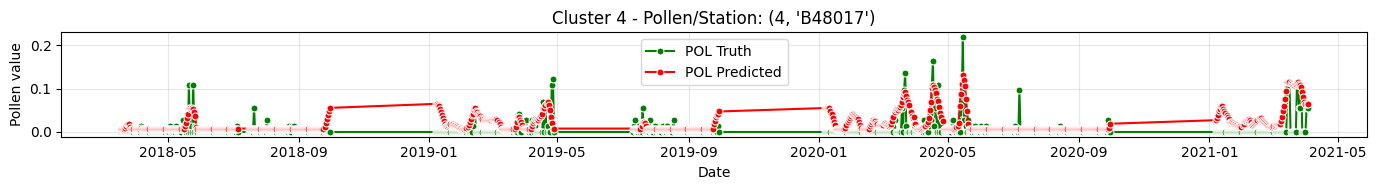

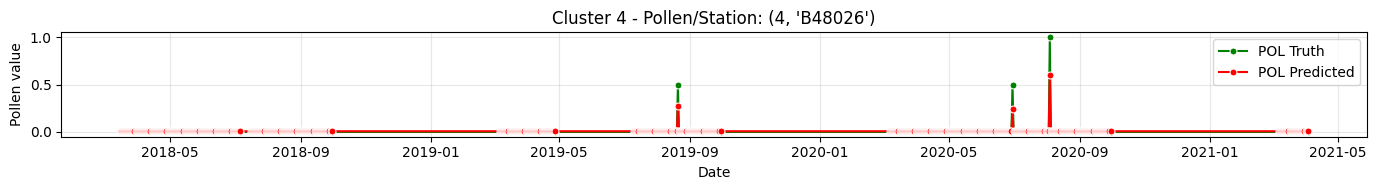

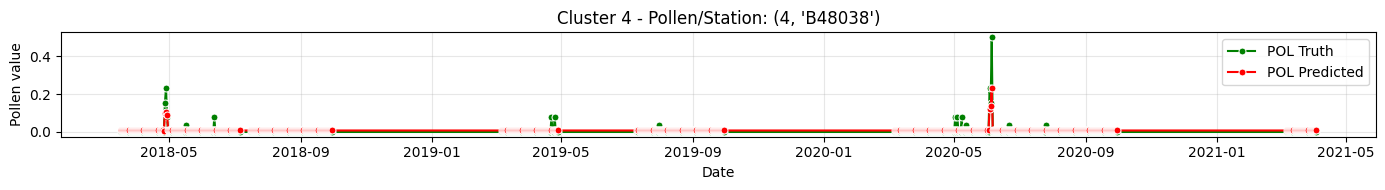

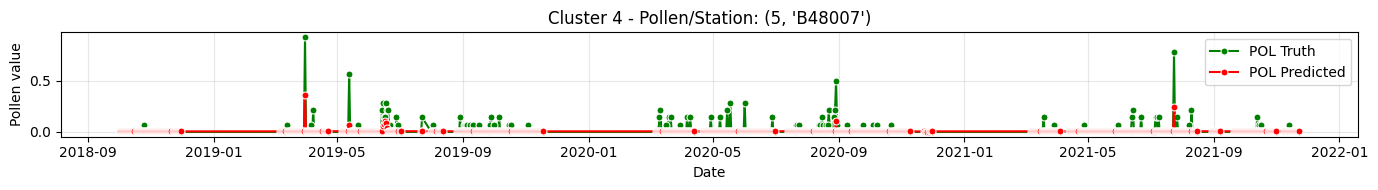

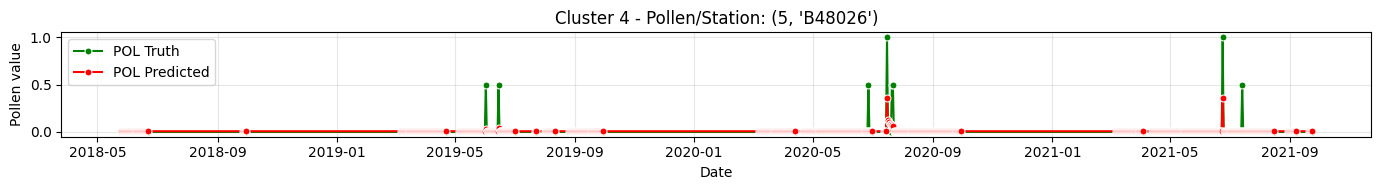

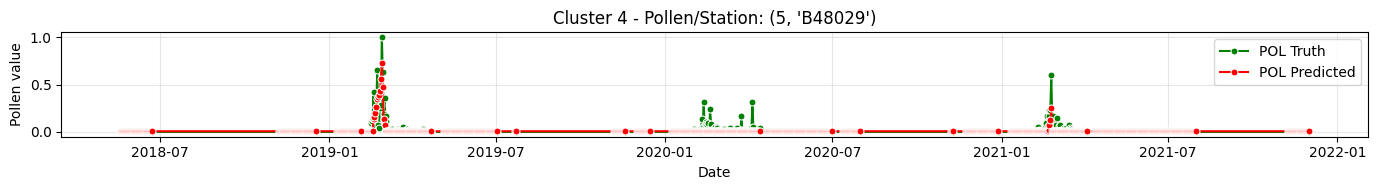

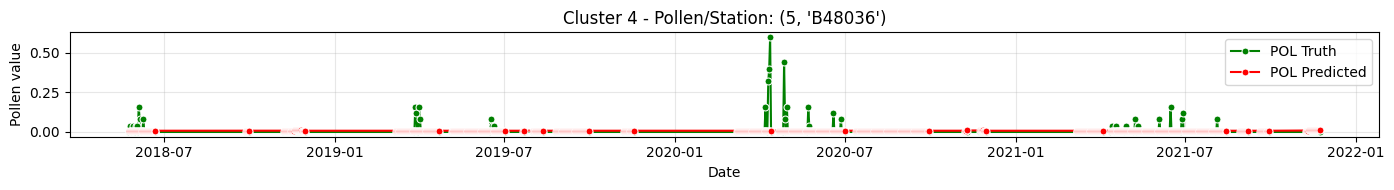

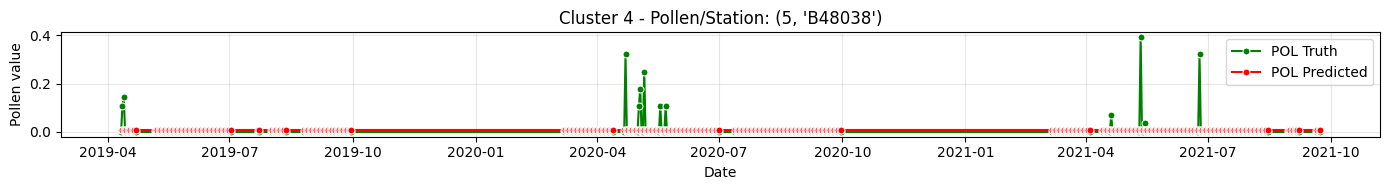

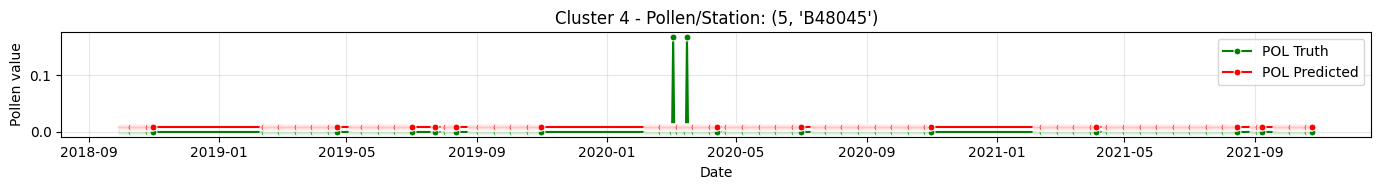

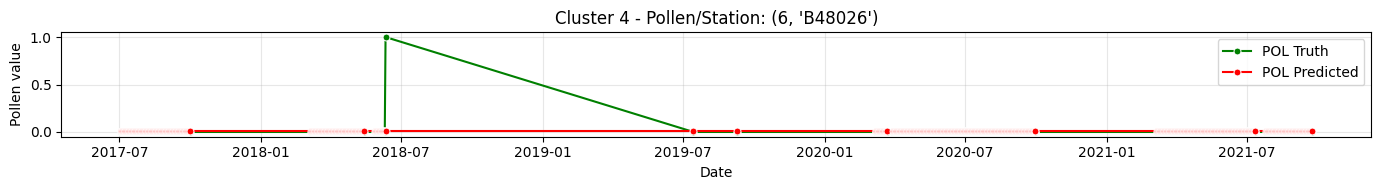

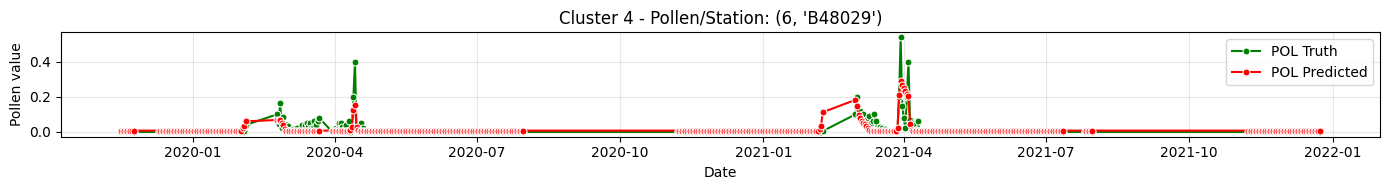

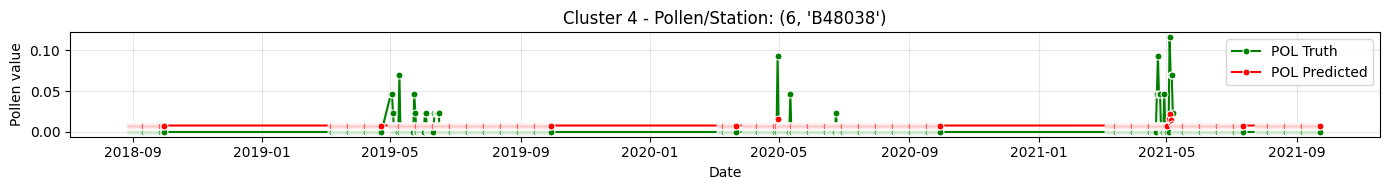

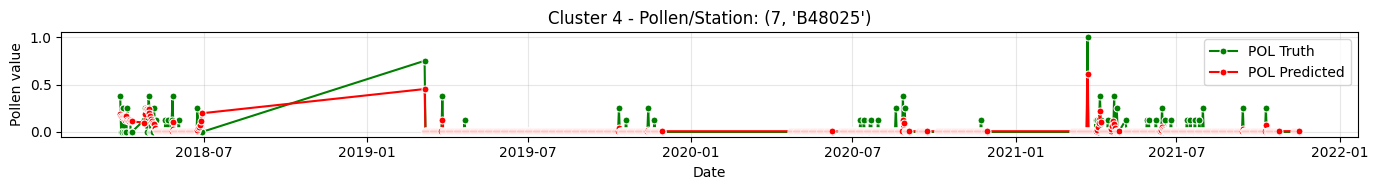

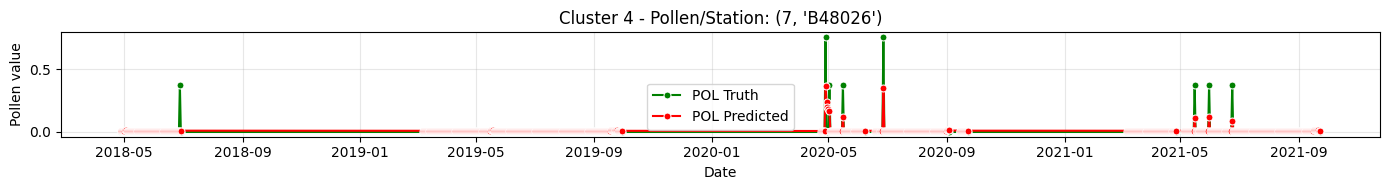

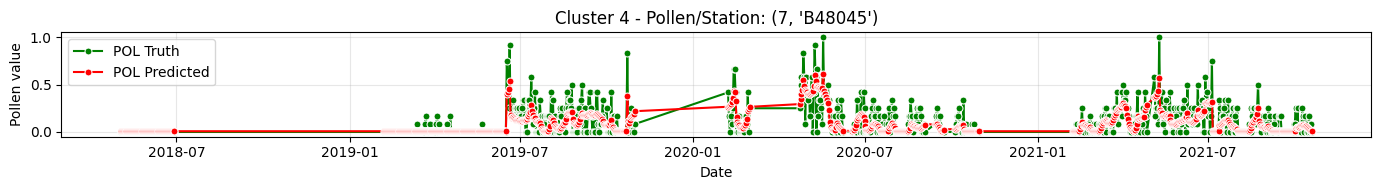

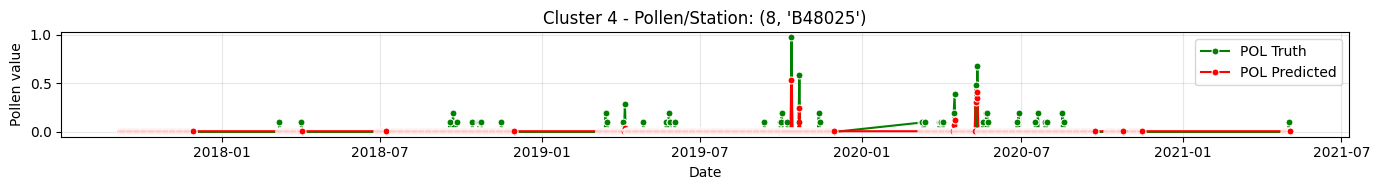

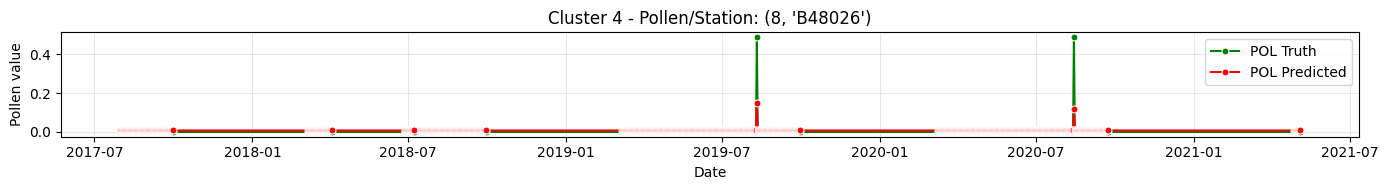

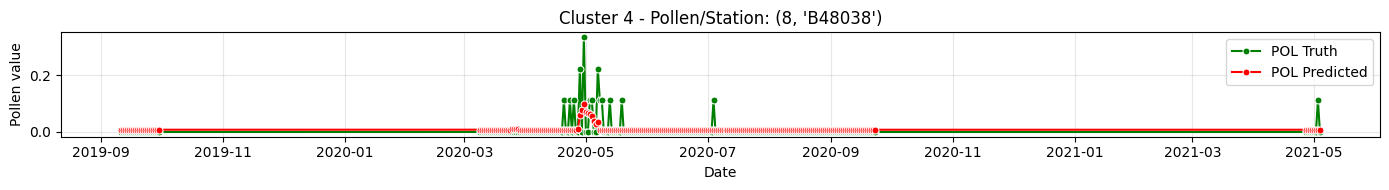

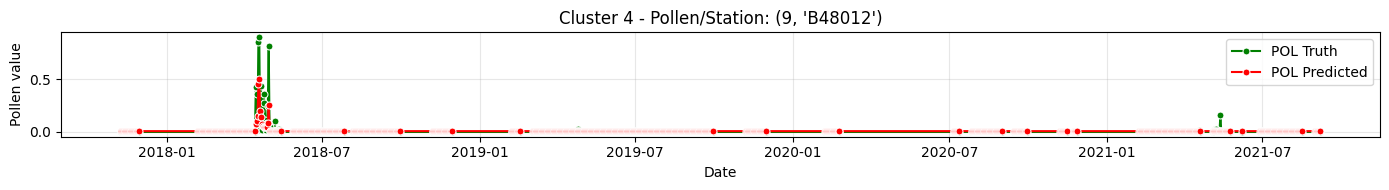

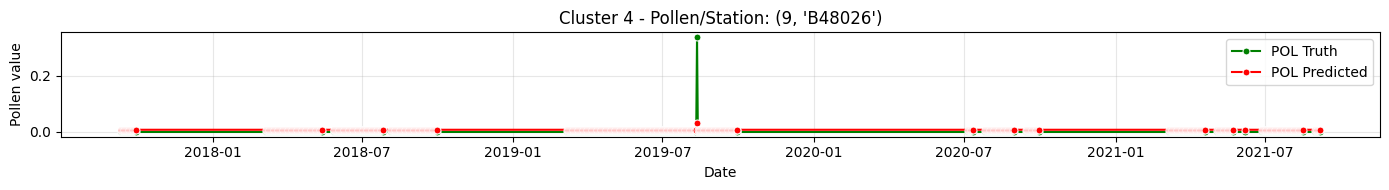

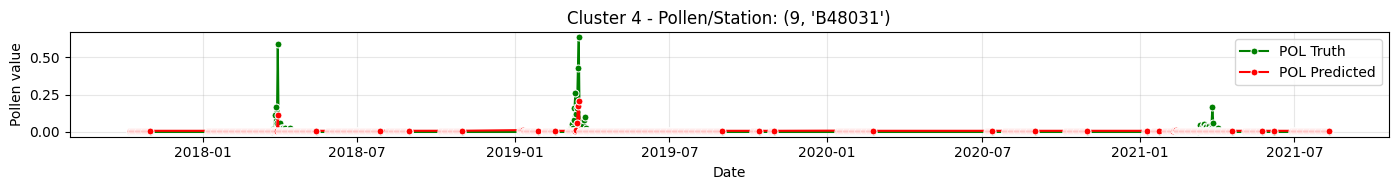

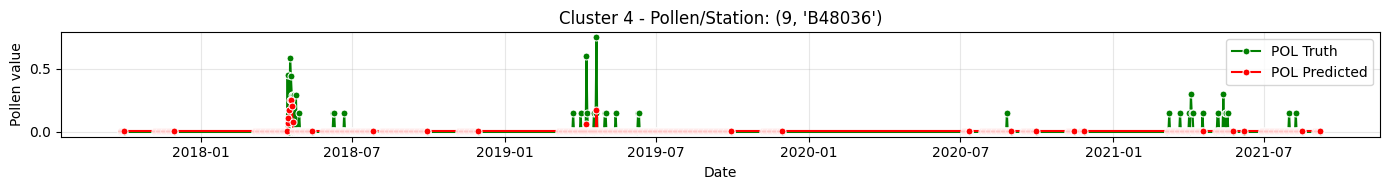

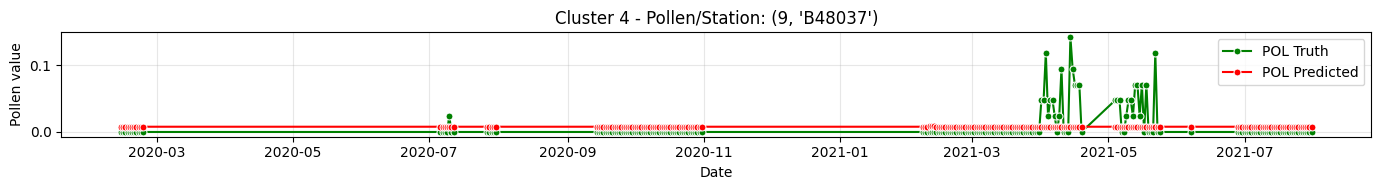

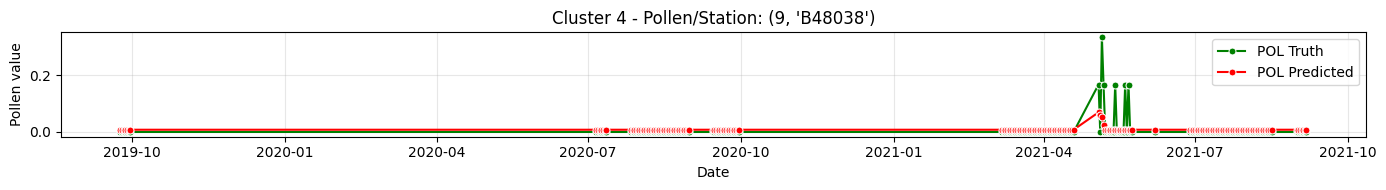

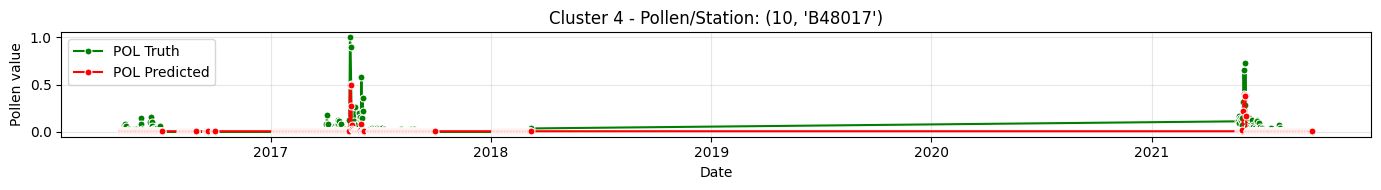

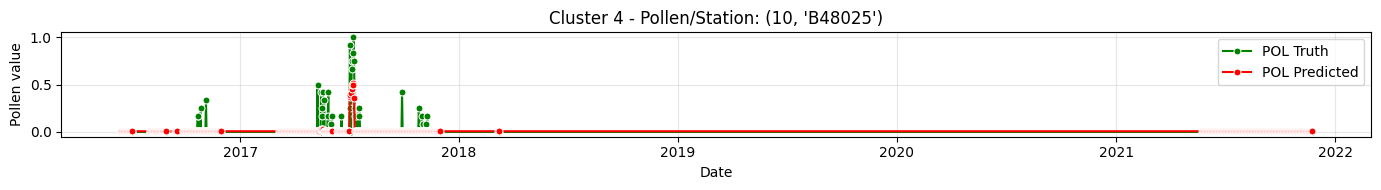

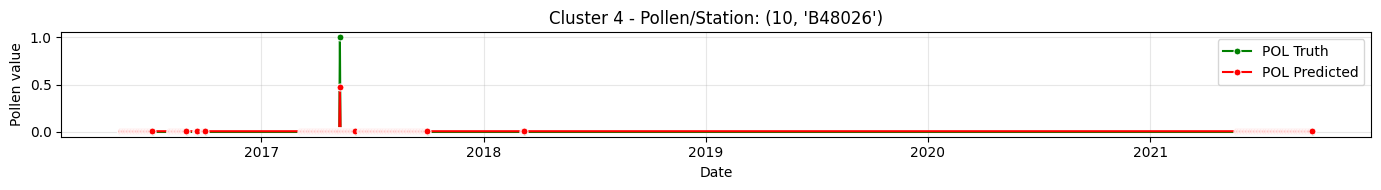

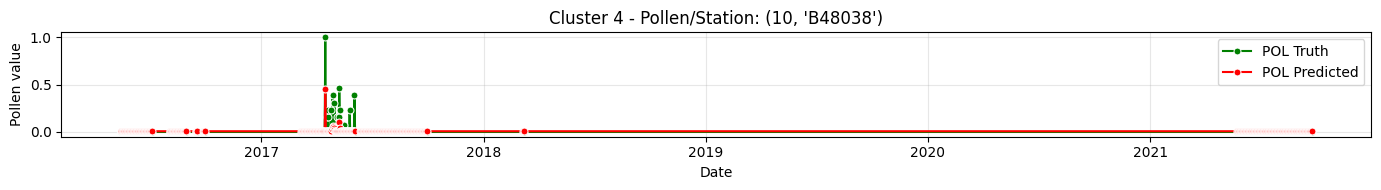

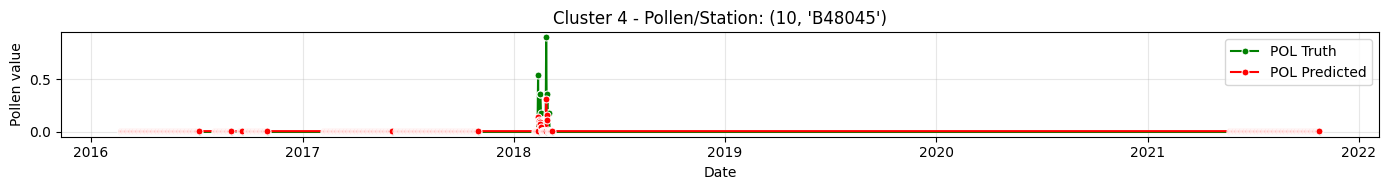

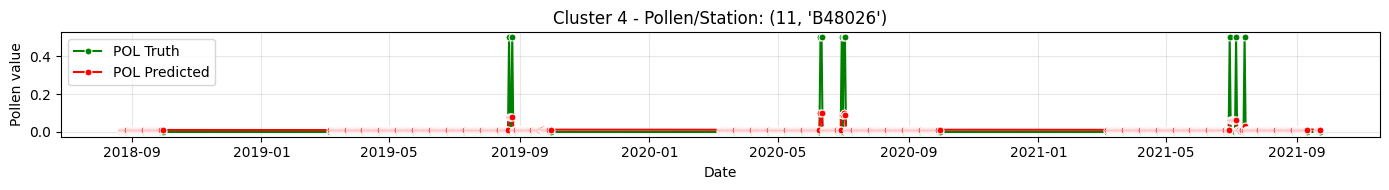

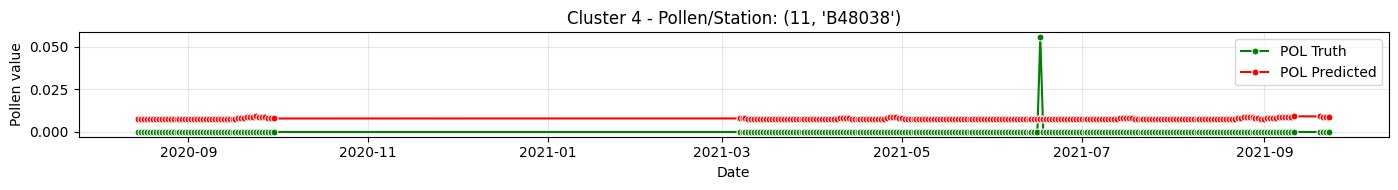

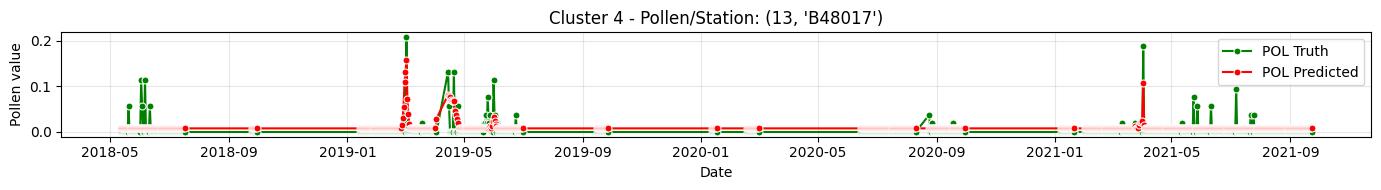

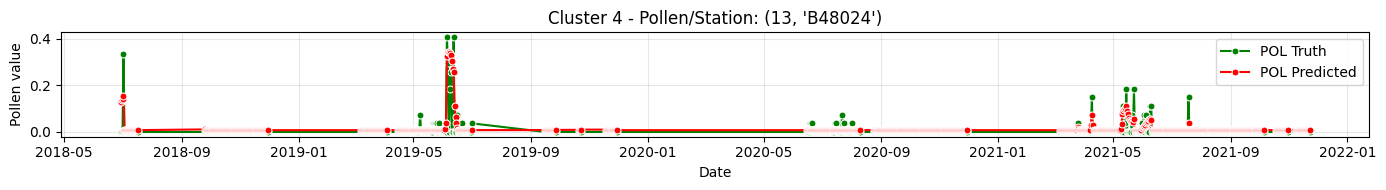

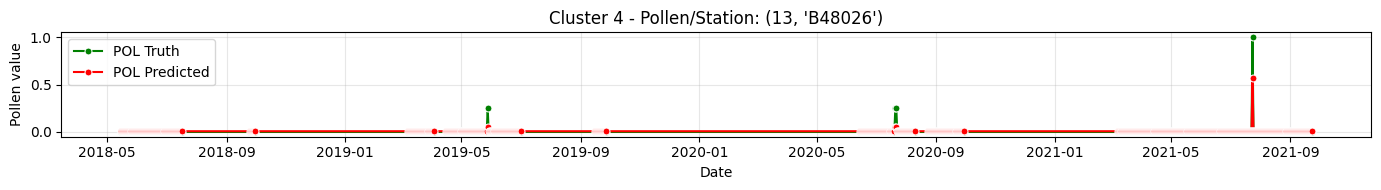

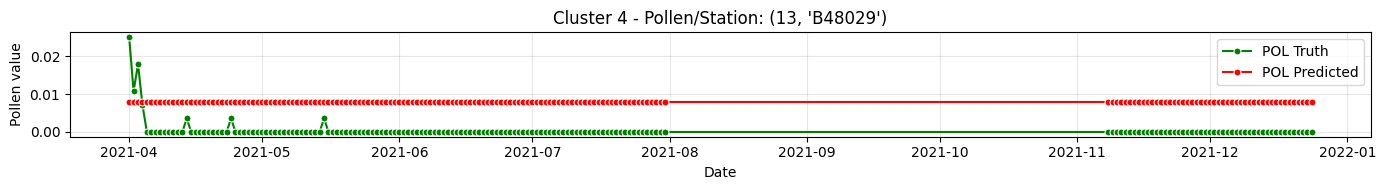

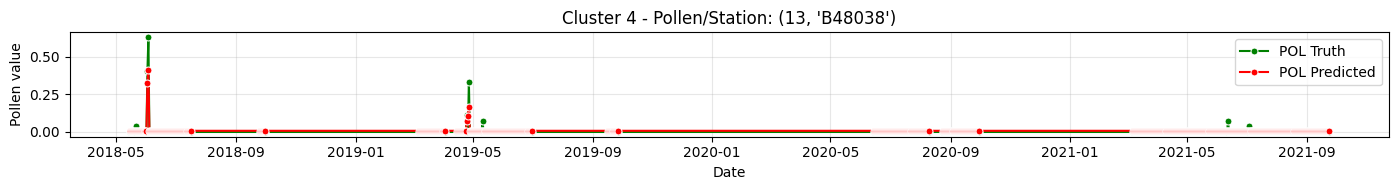

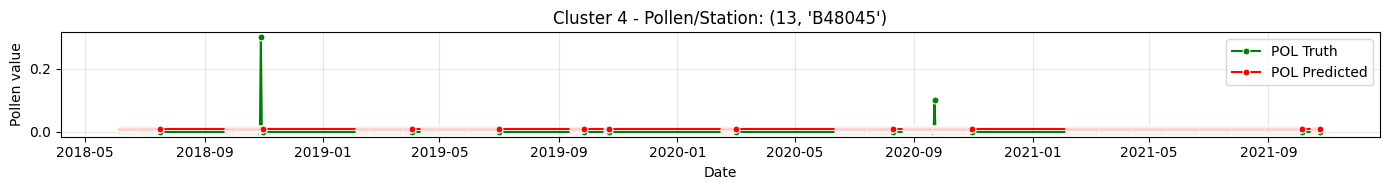

In [46]:
### Per specie/pollen prediction
specie_pollen_dataset = random.choice(trainings)
# specie_pollen_dataset = list(filter(lambda d: d.cluster_n == cluster_wgt.value, trainings))[0]

predictions = specie_pollen_dataset.model.predict(specie_pollen_dataset.valid_dataset, verbose=False).squeeze()
mse = specie_pollen_dataset.model.evaluate(specie_pollen_dataset.valid_dataset, verbose=False)

feat = specie_pollen_dataset.features
for group_idx, specie_group in specie_pollen_dataset.x_valid.groupby(["station_id", "pol_var_id"]):
    species_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        specie_group[feat],
        targets=None,
        sequence_length=window_day_size,
        batch_size=batch_size,
    )
    specie_group = specie_group[: -window_day_size + 1]

    predictions = specie_pollen_dataset.model.predict(species_dataset, verbose=False).squeeze()
    mse = specie_pollen_dataset.model.evaluate(species_dataset, verbose=False)

    plt.figure(figsize=(14, 2))
    plt.title(f"Cluster {specie_pollen_dataset.cluster_n} - Pollen/Station: {group_idx}")
    sns.lineplot(x=specie_group.index, y=specie_group.pol_value_label, marker="o", markersize=5, label="POL Truth", c="green")
    sns.lineplot(x=specie_group.index, y=predictions, marker="o", markersize=5, label="POL Predicted", c="red")
    plt.xlabel("Date")
    plt.ylabel("Pollen value")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

___

# 7. Feature Importance

In [ ]:
sample_df = specie_pollen_dataset.x_valid
print(f"Evaluating feature importance on validation set of cluster {specie_pollen_dataset.cluster_n}")

In [ ]:
features = specie_pollen_dataset.features
x_valid = specie_pollen_dataset.x_valid[features].values
y_valid = specie_pollen_dataset.y_valid[: -window_day_size + 1].values.flatten()
results = []

# Evaluate model baseline with all features
oof_preds = specie_pollen_dataset.model.predict(specie_pollen_dataset.valid_dataset, verbose=0).squeeze()
baseline_mse = ((oof_preds - y_valid)**2).mean()
results.append({'feature': 'BASELINE', 'mse': baseline_mse})

for k, f in tqdm(enumerate(features), total=len(features)):
    x_valid_test = x_valid.copy()

    # shuffle feature k
    np.random.shuffle(x_valid_test[:,k])

    # predict and evaluate mse
    x_valid_ds = tf.keras.preprocessing.timeseries_dataset_from_array(x_valid_test, targets=None, sequence_length=window_day_size, batch_size=batch_size)
    y_pred_shuffled = specie_pollen_dataset.model.predict(x_valid_ds, verbose=0).squeeze() 
    feat_mse = ((y_valid - y_pred_shuffled)**2).mean()
    results.append({'feature': f, 'mse': feat_mse})

In [ ]:
df = pd.DataFrame(results).sort_values('mse')
plt.figure(figsize=(10,28))
plt.title('Model Feature Importance',size=16)
plt.barh(np.arange(len(df)), df.mse)
plt.plot([baseline_mse,baseline_mse], [-1,len(df)], '--', color='orange', label=f'Baseline OOF\nMSE={baseline_mse:.3f}')
plt.xlabel(f'OOF MSE',size=14)
plt.ylabel('Feature',size=14)
plt.yticks(np.arange(len(df)),df.feature.values)
plt.ylim((-1,len(df)))
plt.legend()
plt.show()

___

# 8. Test prediction

In [ ]:
sample_df = specie_pollen_dataset.x_valid
features = specie_pollen_dataset.features
print(f"Testing prediction of validation set of cluster {specie_pollen_dataset.cluster_n}")

In [ ]:
results = []
for _ in tqdm(range(100)):
    # Get random station/pollen
    sample_station_id, sample_pol_var_id = sample_df.sample(1)[["station_id", "pol_var_id"]].iloc[0].values

    # Get selected pollen data
    sample_df = sample_df[(sample_df.station_id == sample_station_id) & (sample_df.pol_var_id == sample_pol_var_id)]

    # Get a sample with some pollen filled
    y_sample = 0
    while y_sample <= 0:
        start_idx = np.random.randint(len(sample_df)-window_day_size)
        end_idx = start_idx + window_day_size

        x_sample = sample_df.iloc[start_idx : end_idx][features]
        y_sample = sample_df.iloc[start_idx+window_day_size]["pol_value_label"]

    x_sample_ds = tf.keras.preprocessing.timeseries_dataset_from_array(x_sample, targets=None, sequence_length=window_day_size, batch_size=1)
    y_sample_pred = specie_pollen_dataset.model.predict(x_sample_ds, verbose=False).squeeze()
    results.append([y_sample, y_sample_pred])
results = np.array(results)

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(results)), results[:,0], c="blue", label="truth");
plt.plot(np.arange(len(results)), results[:,1], c="red", label="pred");
plt.xlabel('Entry')
plt.ylabel('pol value')
plt.tight_layout()
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12, 2))
diff = results[:,1] - results[:,0]
plt.bar(np.arange(100), diff)
plt.xlabel('Data point')
plt.ylabel('Difference')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.hist(diff, bins=50);
plt.xlabel('Prediction diff')
plt.ylabel('Distr')
plt.tight_layout()
plt.show()